In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import np_utils
from skimage.color import gray2rgb, label2rgb

In [2]:
# get dataset and split it into two datasets (training, testing)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
# preprocessing the data
def preprocess_data(X, y):
    # normalization
    X = X.astype("float32") / 255
    X = np.array([gray2rgb(img) for img in X])
    # one-hot encoding
    y = np_utils.to_categorical(y)
    return X, y

X_train, y_train = preprocess_data(X_train, y_train)
X_test, y_test = preprocess_data(X_test, y_test)

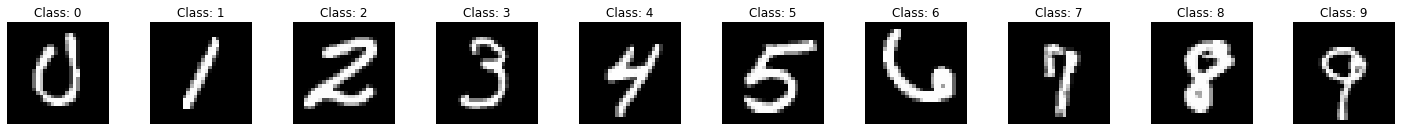

In [4]:
numbers = []
for i in range(10):
    indexes = np.where(np.argmax(y_test, axis=1) == i)
    all_indexes = np.hstack(indexes)
    numbers.append(np.random.choice(all_indexes))

# show examples
fig, axes = plt.subplots(1, 10, figsize=(20, 3))
fig.tight_layout()
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[numbers][i])
    ax.title.set_text(f'Class: {np.argmax(y_test[numbers][i])}')
    ax.axis('off')

In [5]:
print("x_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

x_train shape: (60000, 28, 28, 3)
60000 train samples
10000 test samples


In [6]:
import keras
import tensorflow as tf

In [7]:
model = keras.Sequential(
    [
        keras.Input(shape=np.shape(X_train)[1:]),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(3, 3)),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation="softmax"),
    ]
)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 32)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 21,386
Trainable params: 21,386
Non-trainable params: 0
____________________________________________________

In [9]:
model.fit(X_train, y_train, epochs=5, batch_size=20, validation_split=0.1)

Epoch 1/5
2700/2700 [==============================] - 27s 10ms/step - loss: 0.2732 - accuracy: 0.9176 - val_loss: 0.0869 - val_accuracy: 0.9767
Epoch 2/5
2700/2700 [==============================] - 20s 7ms/step - loss: 0.1357 - accuracy: 0.9576 - val_loss: 0.0727 - val_accuracy: 0.9793
Epoch 3/5
2700/2700 [==============================] - 17s 6ms/step - loss: 0.1092 - accuracy: 0.9660 - val_loss: 0.0566 - val_accuracy: 0.9833
Epoch 4/5
2700/2700 [==============================] - 19s 7ms/step - loss: 0.0967 - accuracy: 0.9700 - val_loss: 0.0545 - val_accuracy: 0.9855
Epoch 5/5
2700/2700 [==============================] - 17s 6ms/step - loss: 0.0903 - accuracy: 0.9721 - val_loss: 0.0509 - val_accuracy: 0.9853


In [10]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Test loss:", '\t', loss)
print("Test accuracy:", '\t', accuracy)

Test loss: 	 0.05293431505560875
Test accuracy: 	 0.9835000038146973


### 1. LIME

In [11]:
from lime import lime_image

In [12]:
explainer = lime_image.LimeImageExplainer(verbose = False)
explanations = [explainer.explain_instance(X_test[numbers][i], classifier_fn=model.predict, top_labels=10, hide_color=0, num_samples=10000) for i in range(10)]

  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 58ms/step


  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


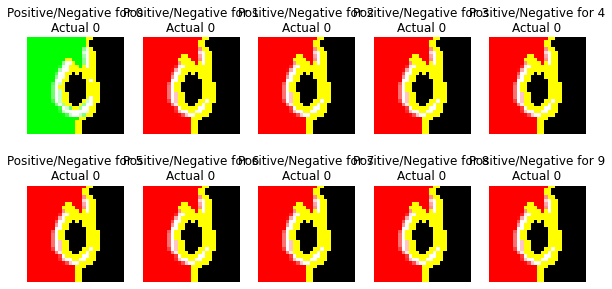

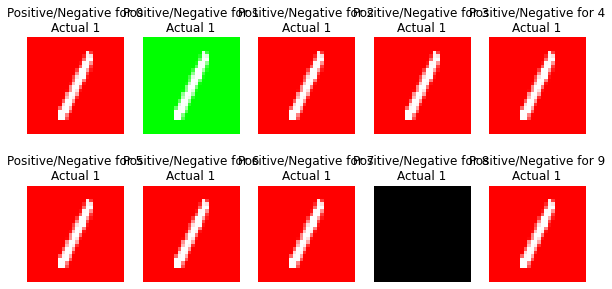

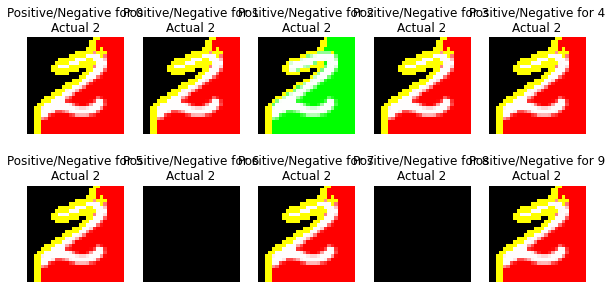

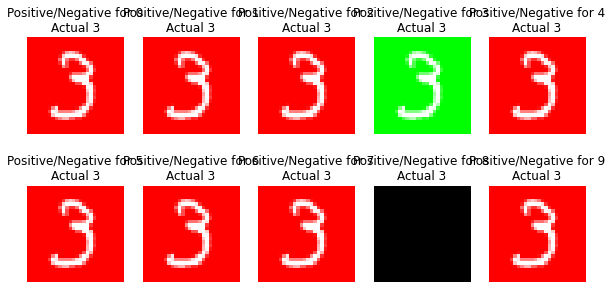

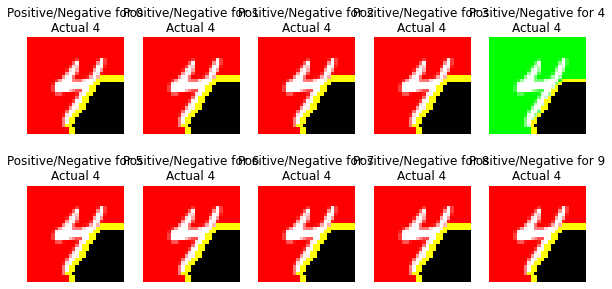

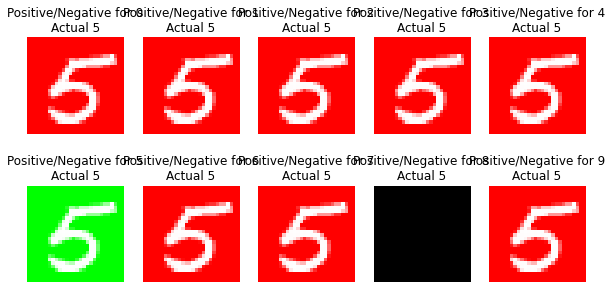

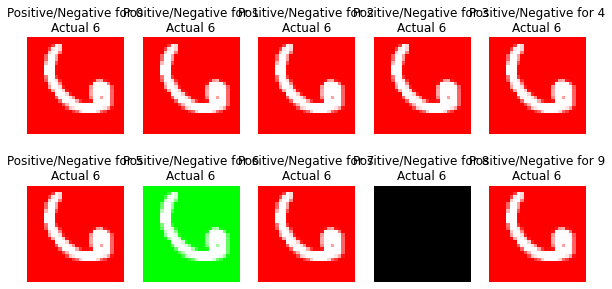

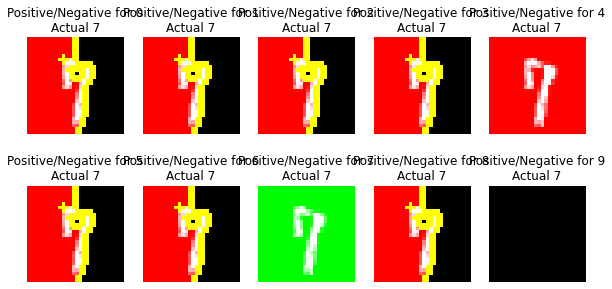

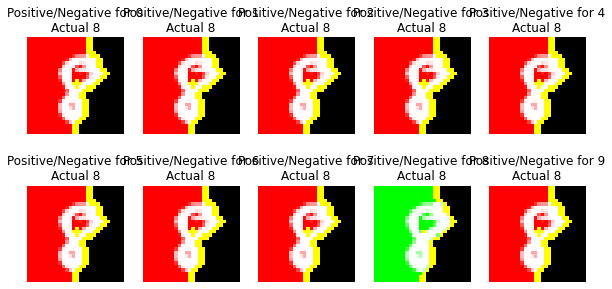

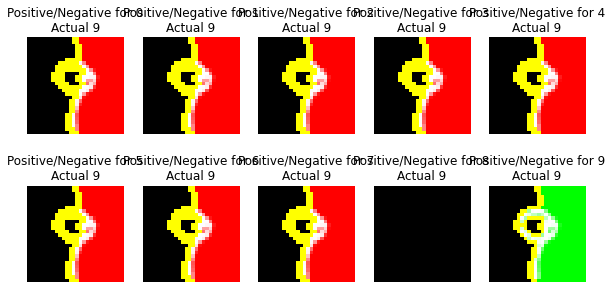

In [14]:
from skimage.segmentation import mark_boundaries

for i, explanation in enumerate(explanations):
    fig, m_axs = plt.subplots(2, 5, figsize = (10, 5))
    for i, c_ax in enumerate(m_axs.flatten()):
        temp, mask = explanation.get_image_and_mask(i, positive_only=False, num_features=1000, hide_rest=True, min_weight=0.01)
        c_ax.imshow(mark_boundaries(temp , mask))
        c_ax.set_title('Positive/Negative for {}\nActual {}'.format(i, explanation.top_labels[0]))
        c_ax.axis('off')